In [2]:
import sys
import glob
import re
import fnmatch
import math
import os
from os import listdir
from os.path import join, isfile, basename

import itertools

import numpy as np
from numpy import float32, int32, uint8, dtype, genfromtxt

from scipy.stats import ttest_ind

import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

import colorsys

In [11]:
# Curry here so we can infer alg names

def mean_diff( alg_list ):
    def diff(x):
        return x['MEAN_'+alg_list[0]] - x['MEAN_'+alg_list[1]]
    return diff

def diff_by_names( pos_name, neg_name ):
    def diff(x):
        return x[pos_name] - x[neg_name]
    return diff

def count_avg( alg_list ):
    def avg(x):
        return ( x['COUNT_'+alg_list[0]] + x['COUNT_'+alg_list[1]] ) / 2.
    return avg

def str_cat( colA, colB, sep=',' ):
    def cat(x):
        return '{}{}{}'.format( x[colA], sep, x[colB] )
    return cat

def log_count_avg( alg_list ):
    def avg(x):
        y = ( x['COUNT_'+alg_list[0]] + x['COUNT_'+alg_list[1]] ) / 2.
        if y <= 0:
            return 0.
        else:
            return math.log(y)
    return avg

def get_alg_names( df ):
    return [ s.replace('COUNT_','') for s in df.columns.values if s.startswith('COUNT') ]

def get_data_f( fixed, v1, v2, line, merged=False, v_template=False ):
    if v_template:
        dirname='templateStatsByLabel'
    else:
        dirname='algStatsByLabel'
        
    if merged:
        ff = '/nrs/saalfeld/john/projects/flyChemStainAtlas/all_evals/{}/{}/mergeLabels_{}_vs_{}_line{}.csv'.format( dirname, fixed, v1, v2, line)
        fr = '/nrs/saalfeld/john/projects/flyChemStainAtlas/all_evals/{}/{}/mergeLabels_{}_vs_{}_line{}.csv'.format( dirname, fixed, v2, v1, line)
        if os.path.isfile( ff ):
            return ff
        elif os.path.isfile( fr ):
            return fr
        else:
            return 'file does not exist'
    else:
        ff = '/nrs/saalfeld/john/projects/flyChemStainAtlas/all_evals/{}/{}/{}_vs_{}_line{}.csv'.format( dirname, fixed, v1, v2, line)
        fr = '/nrs/saalfeld/john/projects/flyChemStainAtlas/all_evals/{}/{}/{}_vs_{}_line{}.csv'.format( dirname, fixed, v2, v1, line)
        if os.path.isfile( ff ):
            return ff
        elif os.path.isfile( fr ):
            return fr
        else:
            return 'file does not exist'

In [3]:
def plot( dist_samples_df, merge, log, ax ):

    alg_list = get_alg_names( dist_samples_df )
    print( alg_list )
    
    md = dist_samples_df.apply( mean_diff(alg_list), axis=1)
    c = dist_samples_df.apply( count_avg(alg_list), axis=1 )
    c_log = dist_samples_df.apply( log_count_avg(alg_list), axis=1 )
    
    dist_samples_df.loc[:, 'md'] = md
    dist_samples_df.loc[:, 'c'] = c
    dist_samples_df.loc[:, 'c_log'] = c_log
    
    dfs = dist_samples_df.sort_values('c', ascending=False )
    if log:
        colors = matplotlib.cm.viridis( dfs['c_log'] / float(max(dfs['c_log']) ))
    else:
        colors = matplotlib.cm.viridis(  dfs['c'] / float(max(dfs['c'])))

    # sns.barplot( x=dist_samples_df['LABEL'], y=md )
    if log:
        plot = ax.scatter(dfs['c_log'], dfs['c_log'], c = dfs['c_log'], cmap = 'viridis' )
    else:
        plot = plt.scatter(c, c, c = c, cmap = 'viridis')
        
    ax.clear()
    ax.bar( range(dfs['md'].shape[0]), dfs['md'], color=colors )
    ax.set_title( 'MEAN '+alg_list[0] + ' - ' + alg_list[1] )
    ax.set_ylabel('mean distance difference (um)')

15
cmtkCOG   cmtkCow
['cmtkCOG', 'cmtkCow']


/groups/saalfeld/home/bogovicj/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/groups/saalfeld/home/bogovicj/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


cmtkCOG   cmtkHideo
['cmtkCOG', 'cmtkHideo']
cmtkCOG   antsRegOwl
['antsRegOwl', 'cmtkCOG']
cmtkCOG   antsRegDog
['antsRegDog', 'cmtkCOG']
cmtkCOG   antsRegYang
['antsRegYang', 'cmtkCOG']
cmtkCow   cmtkHideo
['cmtkCow', 'cmtkHideo']
cmtkCow   antsRegOwl
['antsRegOwl', 'cmtkCow']
cmtkCow   antsRegDog
['antsRegDog', 'cmtkCow']
cmtkCow   antsRegYang
['antsRegYang', 'cmtkCow']
cmtkHideo   antsRegOwl
['antsRegOwl', 'cmtkHideo']
cmtkHideo   antsRegDog
['antsRegDog', 'cmtkHideo']
cmtkHideo   antsRegYang
['antsRegYang', 'cmtkHideo']
antsRegOwl   antsRegDog
['antsRegDog', 'antsRegOwl']
antsRegOwl   antsRegYang
['antsRegOwl', 'antsRegYang']
antsRegDog   antsRegYang
['antsRegDog', 'antsRegYang']


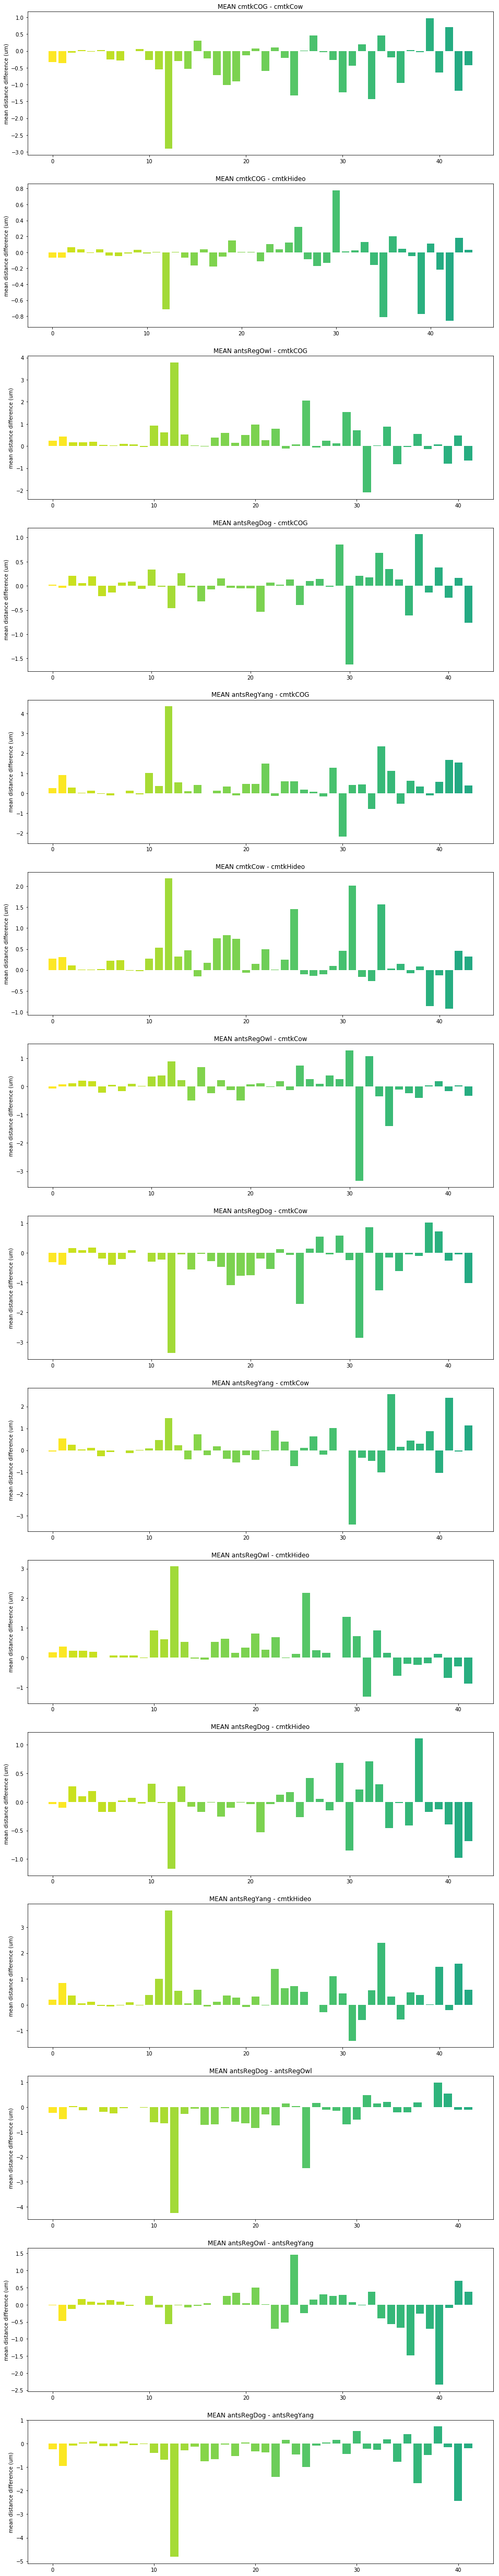

In [4]:
template='F-antsFlip_lo'
line=3

count_threshold = 1000;

alg_list = ['cmtkCOG', 'cmtkCow', 'cmtkHideo', 'antsRegOwl', 'antsRegDog', 'antsRegYang']
n_combs = 0
for alg1,alg2 in itertools.combinations( alg_list,2 ):
    n_combs+=1

fig, axs = plt.subplots(n_combs,1)

print(n_combs)
i = 0
for alg1,alg2 in itertools.combinations( alg_list,2 ):
    print( alg1, ' ', alg2 )
    dist_samples_df = pd.read_csv( get_data_f(template,alg1,alg2,line), index_col=0 )
    valid_df = dist_samples_df[ (dist_samples_df['LABEL'] > 0) & (dist_samples_df['COUNT_'+alg1] > count_threshold) & (dist_samples_df['COUNT_'+alg2] > count_threshold) ]
    plot( valid_df, False, True, axs[i] )
    i += 1

a = fig.set_size_inches( 16, n_combs*6 )

## Statistics over all labels

In [63]:
alg0='cmtkCOG'
alg1='antsRegYang'


In [6]:
dist_samples_df.head()

,COHEND,COUNT_antsRegDog,COUNT_antsRegYang,KRUSKAL,KRUSKALP,LABEL,LINE,MEAN_antsRegDog,MEAN_antsRegYang,MNMAX_antsRegDog,...,SDSTAT_antsRegYang,TSTAT,VRMAX_antsRegDog,VRMAX_antsRegYang,VRMIN_antsRegDog,VRMIN_antsRegYang,VRSTAT_antsRegDog,VRSTAT_antsRegYang,WILCOXON,WILCOXONP
0,-0.027912,908,802,5.533526,0.018655,16,3,6.103969,6.253680,6.582958,...,5.087474,-0.576505,35.401421,29.491427,27.789741,22.793370,31.335178,25.898590,145886.5,0.084027
1,0.070195,3406,3420,5.959611,0.014637,64,3,3.434779,3.286051,3.530272,...,2.073213,2.899301,4.973340,4.565950,4.388964,4.030478,4.681152,4.298214,2611205.5,0.010128
2,NaN,6,0,NaN,NaN,8,3,21.916551,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.465063,136,264,17.352247,0.000031,32,3,11.755835,7.517954,14.186009,...,8.036671,4.424550,164.716560,81.325329,87.722206,51.837080,119.427426,64.711937,2792.0,0.000187
4,0.094860,2026,2812,21.460503,0.000004,2,3,2.643946,2.458396,2.754789,...,1.969683,3.254534,4.055277,4.146164,3.448031,3.613139,3.751654,3.879652,846210.5,0.000721


In [51]:
def load_all_pairs( fixed, v_list, line, v_template=False, merged=False ):
    
    if v_template:
        prefix='TEMPLATE_'
    else:
        prefix='ALG_'
    
    alg0_list = []
    alg1_list = []
    mn0_list = []
    mn1_list = []
    c0_list = []
    c1_list = []
    p_list = []
    t_list = []

    mn0stat_list = []
    mn0min_list = []
    mn0max_list = []
    vr0stat_list = []
    vr0min_list = []
    vr0max_list = []
    sd0stat_list = []
    sd0min_list = []
    sd0max_list = []

    mn1stat_list = []
    mn1min_list = []
    mn1max_list = []
    vr1stat_list = []
    vr1min_list = []
    vr1max_list = []
    sd1stat_list = []
    sd1min_list = []
    sd1max_list = []

    ks_list = []
    kp_list = []

    ws_list = []
    wp_list = []

    cohen_list = []

    for a0,a1 in itertools.combinations( v_list, 2 ):
    #     print( a0, ' ', a1 )
        f = get_data_f( fixed, a0, a1, line, merged=merged, v_template=v_template )
#         print( 'f: ', f )
        alg_names = [a0, a1 ]
        df_wlabels = pd.read_csv(f, index_col=0)
        df = df_wlabels[ df_wlabels.LABEL == -1 ]

        for i,row in df.iterrows():
            m0='MEAN_'+a0
            m1='MEAN_'+a1
            c0='COUNT_'+a0
            c1='COUNT_'+a1
            alg0_list += [a0]
            alg1_list += [a1]
            mn0_list += [row[m0]]
            mn1_list += [row[m1]]
            c0_list += [row[c0]]
            c1_list += [row[c1]]
            p_list += [row['PVAL']]
            t_list += [row['TSTAT']]
            mn0stat_list += [row['MNSTAT_'+a0]]
            mn0min_list += [row['MNMIN_'+a0]]
            mn0max_list += [row['MNMAX_'+a0]]
            vr0stat_list += [row['VRSTAT_'+a0]]
            vr0min_list += [row['VRMIN_'+a0]]
            vr0max_list += [row['VRMAX_'+a0]]
            sd0stat_list += [row['SDSTAT_'+a0]]
            sd0min_list += [row['SDMIN_'+a0]]
            sd0max_list += [row['SDMAX_'+a0]]

            mn1stat_list += [row['MNSTAT_'+a1]]
            mn1min_list += [row['MNMIN_'+a1]]
            mn1max_list += [row['MNMAX_'+a1]]
            vr1stat_list += [row['VRSTAT_'+a1]]
            vr1min_list += [row['VRMIN_'+a1]]
            vr1max_list += [row['VRMAX_'+a1]]
            sd1stat_list += [row['SDSTAT_'+a1]]
            sd1min_list += [row['SDMIN_'+a1]]
            sd1max_list += [row['SDMAX_'+a1]]

            ks_list += [row['KRUSKAL']]
            kp_list += [row['KRUSKALP']]
            ws_list += [row['WILCOXON']]
            wp_list += [row['WILCOXONP']]
            cohen_list += [row['COHEND']]

            # Backwards
            alg0_list += [a1]
            alg1_list += [a0]
            mn0_list += [row[m1]]
            mn1_list += [row[m0]]
            c0_list += [row[c1]]
            c1_list += [row[c0]]
            p_list += [row['PVAL']]
            t_list += [row['TSTAT']]
            mn0stat_list += [row['MNSTAT_'+a1]]
            mn0min_list += [row['MNMIN_'+a1]]
            mn0max_list += [row['MNMAX_'+a1]]
            vr0stat_list += [row['VRSTAT_'+a1]]
            vr0min_list += [row['VRMIN_'+a1]]
            vr0max_list += [row['VRMAX_'+a1]]
            sd0stat_list += [row['SDSTAT_'+a1]]
            sd0min_list += [row['SDMIN_'+a1]]
            sd0max_list += [row['SDMAX_'+a1]]

            mn1stat_list += [row['MNSTAT_'+a0]]
            mn1min_list += [row['MNMIN_'+a0]]
            mn1max_list += [row['MNMAX_'+a0]]
            vr1stat_list += [row['VRSTAT_'+a0]]
            vr1min_list += [row['VRMIN_'+a0]]
            vr1max_list += [row['VRMAX_'+a0]]
            sd1stat_list += [row['SDSTAT_'+a0]]
            sd1min_list += [row['SDMIN_'+a0]]
            sd1max_list += [row['SDMAX_'+a0]]

            ks_list += [row['KRUSKAL']]
            kp_list += [row['KRUSKALP']]
            ws_list += [row['WILCOXON']]
            wp_list += [row['WILCOXONP']]
            cohen_list += [-row['COHEND']]


    merged_dist_df = pd.DataFrame({prefix+'0':alg0_list,
                             prefix+'1':alg1_list,
                             'MEAN_0':mn0_list,
                             'MEAN_1':mn1_list,
                             'COUNT_0':c0_list,
                             'COUNT_1':c1_list,
                             'PVAL':p_list,
                             'TSTAT':t_list,
                             'KRUSKAL':ks_list,
                             'KRUSKALP':kp_list,
                             'WILCOXON':ws_list,
                             'WILCOXONP':wp_list,
                             'COHEN':cohen_list,
                             'MN0':mn0stat_list,
                             'MN0MIN':mn0min_list,
                             'MN0MAX':mn0max_list,
                             'VR0':vr0stat_list,
                             'VR0MIN':vr0min_list,
                             'VR0MAX':vr0max_list,
                             'SD0':sd0stat_list,
                             'SD0MIN':sd0min_list,
                             'SD0MAX':sd0max_list,
                             'MN1':mn1stat_list,
                             'MN1MIN':mn1min_list,
                             'MN1MAX':mn1max_list,
                             'VR1':vr1stat_list,
                             'VR1MIN':vr1min_list,
                             'VR1MAX':vr1max_list,
                             'SD1':sd1stat_list,
                             'SD1MIN':sd1min_list,
                             'SD1MAX':sd1max_list
                                })
    return merged_dist_df

In [52]:
line=3
template = 'F-antsFlip_lo'
merged_dist_df = load_all_pairs( template, alg_list, line, v_template=False )


### difference of means
Positive means that ALG_0 is worse

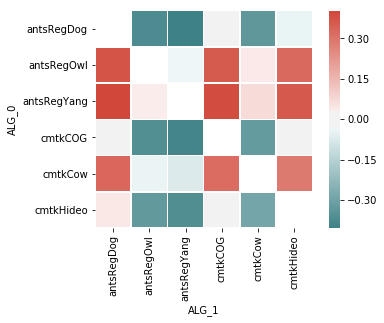

In [53]:
merged_dist_df['MEANDIFF'] = merged_dist_df.apply( mean_diff(['0','1']), axis=1)

cmap = sns.diverging_palette(200, 15, sep=20, as_cmap=True)

piv_md = merged_dist_df[['ALG_0','ALG_1','MEANDIFF']].pivot( index='ALG_0', columns='ALG_1', values='MEANDIFF' )
sns.heatmap( piv_md, cmap=cmap,
           square=True, linewidth=0.5)

### p-values 

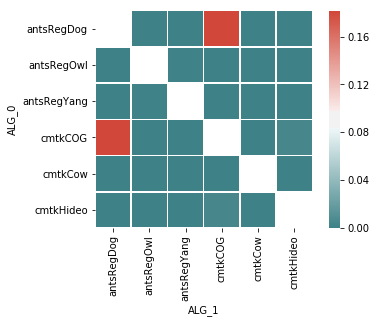

In [45]:
piv_pv = merged_dist_df[['ALG_0','ALG_1','PVAL']].pivot( index='ALG_0', columns='ALG_1', values='PVAL' )
sns.heatmap( piv_pv, cmap=cmap,
           square=True, linewidth=0.5)

## Confidence interval

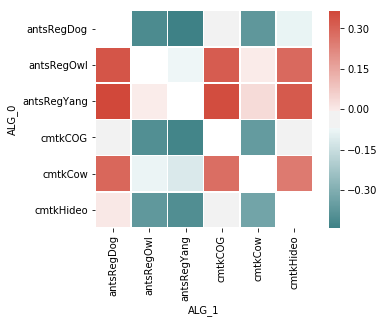

In [46]:

merged_dist_df['MN_MIN_MAX'] = merged_dist_df.apply( diff_by_names('MN0MIN','MN1MAX'), axis=1)
merged_dist_df['MN_MAX_MIN'] = merged_dist_df.apply( diff_by_names('MN0MAX','MN1MIN'), axis=1)

piv_mmm = merged_dist_df[['ALG_0','ALG_1','MN_MIN_MAX']].pivot( index='ALG_0', columns='ALG_1', values='MN_MIN_MAX' )
sns.heatmap( piv_mmm, cmap=cmap,
           square=True, linewidth=0.5)

## Effect size
As measured by Cohen's d

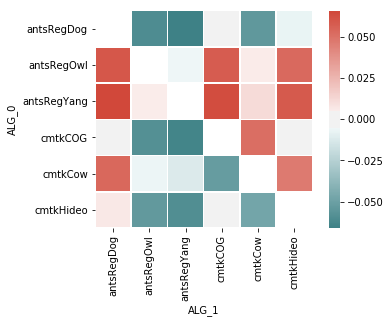

In [47]:
piv_effsz = merged_dist_df[['ALG_0','ALG_1','COHEN']].pivot( index='ALG_0', columns='ALG_1', values='COHEN' )
sns.heatmap( piv_effsz, cmap=cmap,
           square=True, linewidth=0.5)

In [54]:
line=3
alg = 'cmtkCOG'
template_list = ['JFRCtemplate2010', 'JFRC2013_lo', 'F-antsFlip_lo', 'TeforBrain_f']
merged_template_df = load_all_pairs( alg, template_list, line, v_template=True )
merged_template_df



,COHEN,COUNT_0,COUNT_1,KRUSKAL,KRUSKALP,MEAN_0,MEAN_1,MN0,MN0MAX,MN0MIN,...,TEMPLATE_1,TSTAT,VR0,VR0MAX,VR0MIN,VR1,VR1MAX,VR1MIN,WILCOXON,WILCOXONP
0,0.022885,693788.0,645414.0,373.674084,2.966489e-83,4.709804,4.572812,4.709804,4.728540,4.691067,...,JFRC2013_lo,13.233313,36.707501,36.868037,36.546964,34.891053,35.049261,34.732846,9.622711e+10,2.120974e-57
1,-0.022885,645414.0,693788.0,373.674084,2.966489e-83,4.572812,4.709804,4.572812,4.591750,4.553873,...,JFRCtemplate2010,13.233313,34.891053,35.049261,34.732846,36.707501,36.868037,36.546964,9.622711e+10,2.120974e-57
2,0.081117,693788.0,706356.0,10111.204775,0.000000e+00,4.709804,4.219387,4.709804,4.728540,4.691067,...,F-antsFlip_lo,47.989972,36.707501,36.868037,36.546964,36.398550,36.556313,36.240787,9.926502e+10,0.000000e+00
3,-0.081117,706356.0,693788.0,10111.204775,0.000000e+00,4.219387,4.709804,4.219387,4.237877,4.200896,...,JFRCtemplate2010,47.989972,36.398550,36.556313,36.240787,36.707501,36.868037,36.546964,9.926502e+10,0.000000e+00
4,0.053176,693788.0,777128.0,5850.382904,0.000000e+00,4.709804,4.385969,4.709804,4.728540,4.691067,...,TeforBrain_f,32.194733,36.707501,36.868037,36.546964,37.423608,37.578251,37.268964,1.032437e+11,0.000000e+00
5,-0.053176,777128.0,693788.0,5850.382904,0.000000e+00,4.385969,4.709804,4.385969,4.403844,4.368094,...,JFRCtemplate2010,32.194733,37.423608,37.578251,37.268964,36.707501,36.868037,36.546964,1.032437e+11,0.000000e+00
6,0.059169,645414.0,706356.0,6242.623884,0.000000e+00,4.572812,4.219387,4.572812,4.591750,4.553873,...,F-antsFlip_lo,34.361433,34.891053,35.049261,34.732846,36.398550,36.556313,36.240787,8.801894e+10,0.000000e+00
7,-0.059169,706356.0,645414.0,6242.623884,0.000000e+00,4.219387,4.572812,4.219387,4.237877,4.200896,...,JFRC2013_lo,34.361433,36.398550,36.556313,36.240787,34.891053,35.049261,34.732846,8.801894e+10,0.000000e+00
8,0.031022,645414.0,777128.0,3013.291856,0.000000e+00,4.572812,4.385969,4.572812,4.591750,4.553873,...,TeforBrain_f,18.420761,34.891053,35.049261,34.732846,37.423608,37.578251,37.268964,9.143770e+10,0.000000e+00
9,-0.031022,777128.0,645414.0,3013.291856,0.000000e+00,4.385969,4.572812,4.385969,4.403844,4.368094,...,JFRC2013_lo,18.420761,37.423608,37.578251,37.268964,34.891053,35.049261,34.732846,9.143770e+10,0.000000e+00


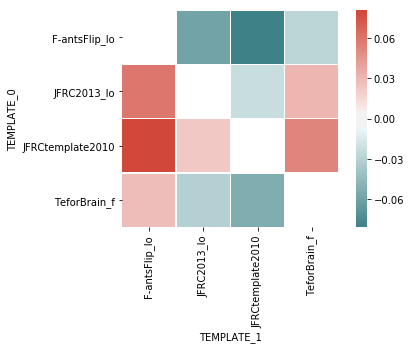

In [56]:

piv_template_md = merged_template_df[['TEMPLATE_0','TEMPLATE_1','COHEN']].pivot( index='TEMPLATE_0', columns='TEMPLATE_1', values='COHEN' )
sns.heatmap( piv_template_md, cmap=cmap,
           square=True, linewidth=0.5)

## Time and memory usage

In [61]:
time_mem_df = pd.read_csv( '/nrs/saalfeld/john/projects/flyChemStainAtlas/all_evals/time_mem_data.csv',
                         dtype={'ALG':str, 'TEMPLATE':str, 'THREADS':np.int32,
                                'TIME':np.float32, 'AVGMEM':np.float32, 'MAXMEM':np.float32})

time_mem_df['EXP'] = time_mem_df[['TEMPLATE','ALG']].apply( str_cat('TEMPLATE','ALG'), axis=1 )
# time_mem_df.dtypes

In [45]:
def mult_col( colA, colB ):
    def mult(x):
        return x[colA]*x[colB]
    return mult

time_mem_df['CPUTIME'] = time_mem_df[['TIME','THREADS']].apply( mult_col('TIME','THREADS'), axis=1 )

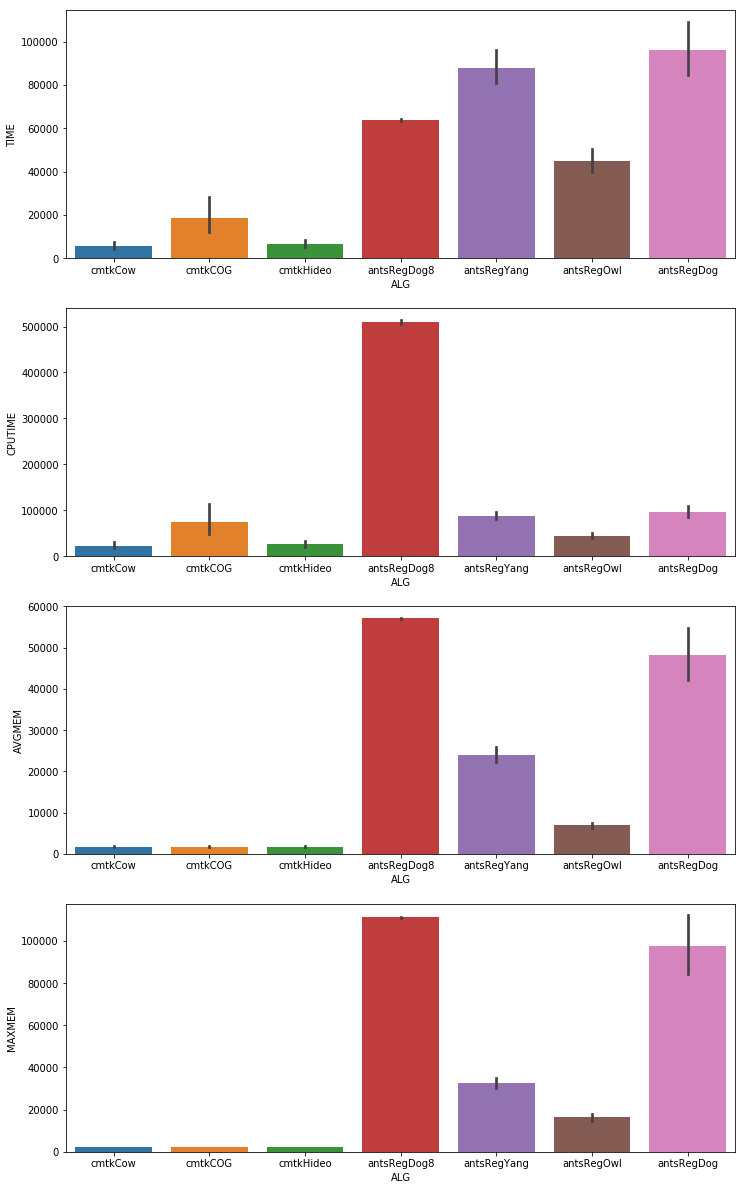

In [57]:
# fig= plt.figure()

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 21), sharex=False)

g1=sns.factorplot( x='ALG', y='TIME',    kind='bar', data=time_mem_df, ax=ax1 )
g2=sns.factorplot( x='ALG', y='CPUTIME', kind='bar', data=time_mem_df, ax=ax2 )
g3=sns.factorplot( x='ALG', y='AVGMEM',  kind='bar', data=time_mem_df, ax=ax3 )
g4=sns.factorplot( x='ALG', y='MAXMEM',  kind='bar', data=time_mem_df, ax=ax4 )

# close the extra figures
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)
plt.close(g4.fig)

# ax1.set_xticklabels(rotation=30) # This doesn't work with subplots :(